## 开始之前
  在正式开始之前，说一下我们要做什么。我们需要做的是分割数据集和优化梯度下降算法，所以我们需要做以下几件事：
  1. 分割数据集    
  2. 优化梯度下降算法，主要分以下几种：  
     2.1 不使用任何优化算法    
     2.2 mini-batch梯度下降法  
     2.3 使用具有动量的梯度下降算法  
     2.4 使用Adam算法  

   到目前为止，我们始终都是在使用梯度下降法学习，本文中，我们将使用一些更加高级的优化算法，利用这些优化算法，通常可以提高我们算法的收敛速度，并在最终得到更好的分离结果。这些方法可以加快学习速度，甚至可以为成本函数提供更好的最终值，在相同的结果下，有一个好的优化算法可以是等待几天和几个小时之间的差异。
   我们想象一下成本函数 $J$，最小化成本就像找到丘陵的最低点，在训练的每一步中，都会按照某个方向更新参数，以尽可能达到最低点。它类似于最快的下山的路，如下图：<img src="images/cost.jpg" style="width:650px;height:300px;">

## 导入库函数

In [25]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

import opt_utils 
import testCase 

plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


梯度下降  
  在机器学习中，最简单就是没有任何优化的梯度下降(GD,Gradient Descent)，我们每一次循环都是对整个训练集进行学习，这叫做批量梯度下降(Batch Gradient Descent)，我们之前说过了最核心的参数更新的公式，这里我们再来看一下：
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{1}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{2}$$

- $l$是指当前的层数  
- $\alpha$是学习率  

所有的参数都在一个叫做`parameters`的字典类型的变量里面，我们来看看它怎样实现的吧，虽然我们已经实现过它很多次了

In [4]:
def update_parameters_with_gd(parameters,grads,learning_rate):
    """
    使用梯度下降更新参数
    
    参数：
        parameters - 字典，包含了要更新的参数：
            parameters['W' + str(l)] = Wl
            parameters['b' + str(l)] = bl
        grads - 字典，包含了每一个梯度值用以更新参数
            grads['dW' + str(l)] = dWl
            grads['db' + str(l)] = dbl
        learning_rate - 学习率
        
    返回值：
        parameters - 字典，包含了更新后的参数
    """
    
    L = len(parameters) // 2 #神经网络的层数
    
    #更新每个参数
    for l in range(L):
        parameters["W" + str(l +1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l +1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    
    return parameters


我们来测试一下:

In [28]:
#测试update_parameters_with_gd
print("-------------测试update_parameters_with_gd-------------")
parameters , grads , learning_rate = testCase.update_parameters_with_gd_test_case()
parameters = update_parameters_with_gd(parameters,grads,learning_rate)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))


-------------测试update_parameters_with_gd-------------
W1 = [[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 = [[ 1.74604067]
 [-0.75184921]]
W2 = [[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 = [[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]


测试结果：   
W1 = [[ 1.63535156 -0.62320365 -0.53718766]  
 [-1.07799357  0.85639907 -2.29470142]]  
b1 = [[ 1.74604067]  
 [-0.75184921]]  
W2 = [[ 0.32171798 -0.25467393  1.46902454]  
 [-2.05617317 -0.31554548 -0.3756023 ]  
 [ 1.1404819  -1.09976462 -0.1612551 ]]    
b2 = [[-0.88020257]  
 [ 0.02561572]  
 [ 0.57539477]]  

由梯度下降算法演变来的还有`随机梯度下降（SGD）`算法和`小批量梯度下降`算法，随机梯度下降（SGD），相当于小批量梯度下降，但是和mini-batch不同的是其中每个小批量(mini-batch)仅有1个样本，和梯度下降不同的是你一次只能在一个训练样本上计算梯度，而不是在整个训练集上计算梯度。我们来看一下它们的差异：



- 批量梯度下降，又叫梯度下降
```python
X = data_input
Y = labels

parameters = initialize_parameters(layers_dims)
for i in range(0,num_iterations):
    #前向传播
    A,cache = forward_propagation(X,parameters)
    #计算损失
    cost = compute_cost(A,Y)
    #反向传播
    grads = backward_propagation(X,Y,cache)
    #更新参数
    parameters = update_parameters(parameters,grads)
```

- 随机梯度下降算法：
```python
X = data_input
Y = labels
parameters = initialize_parameters(layers_dims)
for i in range(0, num_iterations):
    for j in range(0, m):
        # 前向传播
        a, caches = forward_propagation(X[:,j], parameters)
        # 计算损失
        cost = compute_cost(a, Y[:,j])
        # 反向传播
        grads = backward_propagation(a, caches, parameters)
        # 更新参数
        parameters = update_parameters(parameters, grads)
```

 
  在随机梯度下降中，在更新梯度之前，只使用1个训练样本。 当训练集较大时，随机梯度下降可以更快，但是参数会向最小值摆动，而不是平稳地收敛，我们来看一下比较图:

<img src="images/kiank_sgd.png" style="width:750px;height:250px;">
<caption><center> <u> <font color='purple'> **图 1** </u><font color='purple'>  **SGD vs GD**<br> </center></caption>


    
    
  在实际中，更好的方法是使用小批量(mini-batch)梯度下降法，小批量梯度下降法是一种综合了梯度下降法和随机梯度下降法的方法，在它的每次迭代中，既不是选择全部的数据来学习，也不是选择一个样本来学习，而是把所有的数据集分割为一小块一小块的来学习，它会随机选择一小块（mini-batch），块大小一般为2的n次方倍。一方面，充分利用的GPU的并行性，更一方面，不会让计算时间特别长，来看一下比较图：

<img src="images/kiank_minibatch.png" style="width:750px;height:250px;">
<caption><center> <u> <font color='purple'> **图 2** </u>: <font color='purple'>  **SGD vs Mini-Batch GD**<br> </center></caption>

我们现在从训练集中分割出mini-batch

##   Mini-Batch Gradient descent

我们要使用mini-batch要经过两个步骤：  
  1. 把训练集打乱，但是X和Y依旧是一一对应的，之后，X的第i列是与Y中的第i个标签对应的样本。乱序步骤确保将样本被随机分成不同的小批次。如下图，X和Y的每一列代表一个样本

<img src="images/kiank_shuffle.png" style="width:550px;height:300px;">

2. 切分，我们把训练集打乱之后，我们就可以对它进行切分了。这里切分的大小是64，如下图：

<img src="images/kiank_partition.png" style="width:550px;height:300px;">

我们先来看看分割后如何获取第一和第二个mini-batch吧~

In [ ]:
#第一个mini-batch
first_mini_batch_X = shuffled_X[:, 0 : mini_batch_size]
#第二个mini-batch
second_mini_batch_X = shuffled_X[:, mini_batch_size : 2 * mini_batch_size]

...


这可能会有点不好理解，但是没关系，我们下面会有一些代码来帮你理解，我们首先来获取mini-batch

In [7]:
def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
    """
    从（X，Y）中创建一个随机的mini-batch列表
    
    参数：
        X - 输入数据，维度为(输入节点数量，样本的数量)
        Y - 对应的是X的标签，【1 | 0】（蓝|红），维度为(1,样本的数量)
        mini_batch_size - 每个mini-batch的样本数量
        
    返回：
        mini-bacthes - 一个同步列表，维度为（mini_batch_X,mini_batch_Y）
        
    """
    
    np.random.seed(seed) #指定随机种子
    m = X.shape[1]
    mini_batches = []
    
    #第一步：打乱顺序
    permutation = list(np.random.permutation(m)) #它会返回一个长度为m的随机数组，且里面的数是0到m-1
    shuffled_X = X[:,permutation]   #将每一列的数据按permutation的顺序来重新排列。
    shuffled_Y = Y[:,permutation].reshape((1,m))
    
    """
    #博主注：
    #如果你不好理解的话请看一下下面的伪代码，看看X和Y是如何根据permutation来打乱顺序的。
    x = np.array([[1,2,3,4,5,6,7,8,9],
				  [9,8,7,6,5,4,3,2,1]])
    y = np.array([[1,0,1,0,1,0,1,0,1]])
    
    random_mini_batches(x,y)
    permutation= [7, 2, 1, 4, 8, 6, 3, 0, 5]
    shuffled_X= [[8 3 2 5 9 7 4 1 6]
                 [2 7 8 5 1 3 6 9 4]]
    shuffled_Y= [[0 1 0 1 1 1 0 1 0]]
    """
    
    #第二步，分割
    num_complete_minibatches = math.floor(m / mini_batch_size) #把你的训练集分割成多少份,请注意，如果值是99.99，那么返回值是99，剩下的0.99会被舍弃
    for k in range(0,num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k * mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k * mini_batch_size:(k+1)*mini_batch_size]
        """
        #博主注：
        #如果你不好理解的话请单独执行下面的代码，它可以帮你理解一些。
        a = np.array([[1,2,3,4,5,6,7,8,9],
                      [9,8,7,6,5,4,3,2,1],
                      [1,2,3,4,5,6,7,8,9]])
        k=0
        mini_batch_size=3
        print(a[:,0*3:(0+1)*3]) #从第4列到第6列
        '''
        [[1 2 3]
         [9 8 7]
         [1 2 3]]
        '''
        k=1
        mini_batch_size=3
        print(a[:,1*3:(1+1)*3]) #从第4列到第6列
        '''
        [[4 5 6]
         [6 5 4]
         [4 5 6]]
        '''
        k=2
        print(a[:,2*3:(2+1)*3]) #从第7列到第9列
        '''
        [[7 8 9]
         [3 2 1]
         [7 8 9]]
        '''

        #看一下每一列的数据你可能就会好理解一些
        """
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
    
    #如果训练集的大小刚好是mini_batch_size的整数倍，那么这里已经处理完了
    #如果训练集的大小不是mini_batch_size的整数倍，那么最后肯定会剩下一些，我们要把它处理了
    if m % mini_batch_size != 0:
        #获取最后剩余的部分
        mini_batch_X = shuffled_X[:,mini_batch_size * num_complete_minibatches:]
        mini_batch_Y = shuffled_Y[:,mini_batch_size * num_complete_minibatches:]
        
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches


测试一下：

In [8]:
#测试random_mini_batches
print("-------------测试random_mini_batches-------------")
X_assess,Y_assess,mini_batch_size = testCase.random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess,Y_assess,mini_batch_size)

print("第1个mini_batch_X 的维度为：",mini_batches[0][0].shape)
print("第1个mini_batch_Y 的维度为：",mini_batches[0][1].shape)
print("第2个mini_batch_X 的维度为：",mini_batches[1][0].shape)
print("第2个mini_batch_Y 的维度为：",mini_batches[1][1].shape)
print("第3个mini_batch_X 的维度为：",mini_batches[2][0].shape)
print("第3个mini_batch_Y 的维度为：",mini_batches[2][1].shape)


-------------测试random_mini_batches-------------
第1个mini_batch_X 的维度为： (12288, 64)
第1个mini_batch_Y 的维度为： (1, 64)
第2个mini_batch_X 的维度为： (12288, 64)
第2个mini_batch_Y 的维度为： (1, 64)
第3个mini_batch_X 的维度为： (12288, 20)
第3个mini_batch_Y 的维度为： (1, 20)


测试结果：   
-------------测试random_mini_batches-------------  
第1个mini_batch_X 的维度为： (12288, 64)  
第1个mini_batch_Y 的维度为： (1, 64)  
第2个mini_batch_X 的维度为： (12288, 64)  
第2个mini_batch_Y 的维度为： (1, 64)  
第3个mini_batch_X 的维度为： (12288, 20)  
第3个mini_batch_Y 的维度为： (1, 20)  


## Momentum

   由于小批量梯度下降只看到了一个子集的参数更新，更新的方向有一定的差异，所以小批量梯度下降的路径将“振荡地”走向收敛，使用动量可以减少这些振荡，动量考虑了过去的梯度以平滑更新， 我们将把以前梯度的`方向`存储在变量`v`中，从形式上讲，这将是前面的梯度的`指数加权平均值`。我们也可以把V看作是滚下坡的速度，根据山坡的坡度建立动量。我们来看一下下面的图：


<img src="images/opt_momentum.png" style="width:400px;height:250px;">
<caption><center> <u><font color='purple'>**图 3  **</u><font color='purple'>: 红色箭头显示具有动量的小批量梯度下降一步时所采取的方向
蓝色的点显示每个步骤的梯度方向（相对于当前的小批量）
当然我们不仅要观察梯度，还要让$v$影响梯度，然后朝$v$方向前进一步,尽量让前进的方向指向最小值.<br> <font color='black'></center>  

    
   既然我们要影响梯度的方向，而梯度需要使用到dW和db，那么我们就要建立一个和dW和db相同结构的变量来影响他们，我们现在来进行初始化：

In [9]:
def initialize_velocity(parameters):
    """
    初始化速度，velocity是一个字典：
        - keys: "dW1", "db1", ..., "dWL", "dbL" 
        - values:与相应的梯度/参数维度相同的值为零的矩阵。
    参数：
        parameters - 一个字典，包含了以下参数：
            parameters["W" + str(l)] = Wl
            parameters["b" + str(l)] = bl
    返回:
        v - 一个字典变量，包含了以下参数：
            v["dW" + str(l)] = dWl的速度
            v["db" + str(l)] = dbl的速度
    
    """
    L = len(parameters) // 2 #神经网络的层数
    v = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
    
    return v


测一下： 

In [30]:
#测试initialize_velocity
print("-------------测试initialize_velocity-------------")
parameters = testCase.initialize_velocity_test_case()
v = initialize_velocity(parameters)

print('v["dW1"] = ' + str(v["dW1"]))
print('v["db1"] = ' + str(v["db1"]))
print('v["dW2"] = ' + str(v["dW2"]))
print('v["db2"] = ' + str(v["db2"]))


-------------测试initialize_velocity-------------
v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]


结果：   
-------------测试initialize_velocity-------------  
v["dW1"] = [[ 0.  0.  0.]  
 [ 0.  0.  0.]]  
v["db1"] = [[ 0.]  
 [ 0.]]  
v["dW2"] = [[ 0.  0.  0.]  
 [ 0.  0.  0.]  
 [ 0.  0.  0.]]  
v["db2"] = [[ 0.]  
 [ 0.]  
 [ 0.]]  


现在，使用动量实现参数更新。动量更新规则是, for $l = 1, ..., L$: 

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate. All parameters should be stored in the `parameters` dictionary.  Note that the iterator `l` starts at 0 in the `for` loop while the first parameters are $W^{[1]}$ and $b^{[1]}$ (that's a "one" on the superscript). So you will need to shift `l` to `l+1` when coding.

其中：

-  l是当前神经网络的层数
-  $\beta$是动量，是一个实数
- $\alpha$是学习率



In [11]:
def update_parameters_with_momentun(parameters,grads,v,beta,learning_rate):
    """
    使用动量更新参数
    参数：
        parameters - 一个字典类型的变量，包含了以下字段：
            parameters["W" + str(l)] = Wl
            parameters["b" + str(l)] = bl
        grads - 一个包含梯度值的字典变量，具有以下字段：
            grads["dW" + str(l)] = dWl
            grads["db" + str(l)] = dbl
        v - 包含当前速度的字典变量，具有以下字段：
            v["dW" + str(l)] = ...
            v["db" + str(l)] = ...
        beta - 超参数，动量，实数
        learning_rate - 学习率，实数
    返回：
        parameters - 更新后的参数字典
        v - 包含了更新后的速度变量
    """
    L = len(parameters) // 2 
    for l in range(L):
        #计算速度
        v["dW" + str(l + 1)] = beta * v["dW" + str(l + 1)] + (1 - beta) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta * v["db" + str(l + 1)] + (1 - beta) * grads["db" + str(l + 1)]
        
        #更新参数
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v["db" + str(l + 1)]
    
    return parameters,v


 测一下： 

In [31]:
#测试update_parameters_with_momentun
print("-------------测试update_parameters_with_momentun-------------")
parameters,grads,v = testCase.update_parameters_with_momentum_test_case()
update_parameters_with_momentun(parameters,grads,v,beta=0.9,learning_rate=0.01)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print('v["dW1"] = ' + str(v["dW1"]))
print('v["db1"] = ' + str(v["db1"]))
print('v["dW2"] = ' + str(v["dW2"]))
print('v["db2"] = ' + str(v["db2"]))


-------------测试update_parameters_with_momentun-------------
W1 = [[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = [[ 1.74493465]
 [-0.76027113]]
W2 = [[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = [[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]


测试结果：   
-------------测试update_parameters_with_momentun-------------    
W1 = [[ 1.62544598 -0.61290114 -0.52907334]  
 [-1.07347112  0.86450677 -2.30085497]]  
b1 = [[ 1.74493465]  
 [-0.76027113]]  
W2 = [[ 0.31930698 -0.24990073  1.4627996 ]  
 [-2.05974396 -0.32173003 -0.38320915]  
 [ 1.13444069 -1.0998786  -0.1713109 ]]  
b2 = [[-0.87809283]  
 [ 0.04055394]  
 [ 0.58207317]]  
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]  
 [ 0.05024943  0.09008559 -0.06837279]]  
v["db1"] = [[-0.01228902]  
 [-0.09357694]]  
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]  
 [-0.03967535 -0.06871727 -0.08452056]  
 [-0.06712461 -0.00126646 -0.11173103]]  
v["db2"] = [[0.02344157]  
 [0.16598022]  
 [0.07420442]]  

需要注意的是速度`v`是用0来初始化的，因此，该算法需要经过几次迭代才能把速度提升上来并开始跨越更大步伐。当beta=0时，该算法相当于是没有使用momentum算法的标准的梯度下降算法。当beta越大的时候，说明平滑的作用越明显。通常0.9是比较合适的值。那如何才能在开始的时候就保持很快的速度向最小误差那里前进呢？我们来看看下面的Adam算法。

## Adam


  Adam算法是训练神经网络中最有效的算法之一，它是RMSProp算法与Momentum算法的结合体。我们来看看它都干了些什么吧~  
  1. 计算以前的梯度的指数加权平均值，并将其存储在变量$v$（偏差校正前）和$v^{corrected}$ （偏差校正后）中。    
  2. 计算以前梯度的平方的指数加权平均值，并将其存储在变量$s$（偏差校正前）和$s^{corrected}$（偏差校正后）  中。  
  3. 根据1和2更新参数。    
我们来看一下它所依赖的公式：  


$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_1)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$



其中：

-  t ：当前迭代的次数
-  l：当前神经网络的层数
-  $\beta_1$和 $\beta_2$ 控制两个指数加权平均值的超参数
-  $\alpha$ ：学习率
-  $\varepsilon$：一个非常小的数，用于避免除零操作，一般为$1^{-8}$



先来初始化Adam所需要的参数：

In [13]:
def initialize_adam(parameters):
    """
    初始化v和s，它们都是字典类型的变量，都包含了以下字段：
        - keys: "dW1", "db1", ..., "dWL", "dbL" 
        - values：与对应的梯度/参数相同维度的值为零的numpy矩阵
    
    参数：
        parameters - 包含了以下参数的字典变量：
            parameters["W" + str(l)] = Wl
            parameters["b" + str(l)] = bl
    返回：
        v - 包含梯度的指数加权平均值，字段如下：
            v["dW" + str(l)] = ...
            v["db" + str(l)] = ...
        s - 包含平方梯度的指数加权平均值，字段如下：
            s["dW" + str(l)] = ...
            s["db" + str(l)] = ...
    
    """
    
    L = len(parameters) // 2
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
        
        s["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
    
    return (v,s)



测一下： 

In [32]:
#测试initialize_adam
print("-------------测试initialize_adam-------------")
parameters = testCase.initialize_adam_test_case()
v,s = initialize_adam(parameters)

print('v["dW1"] = ' + str(v["dW1"])) 
print('v["db1"] = ' + str(v["db1"])) 
print('v["dW2"] = ' + str(v["dW2"])) 
print('v["db2"] = ' + str(v["db2"])) 
print('s["dW1"] = ' + str(s["dW1"])) 
print('s["db1"] = ' + str(s["db1"])) 
print('s["dW2"] = ' + str(s["dW2"])) 
print('s["db2"] = ' + str(s["db2"])) 


-------------测试initialize_adam-------------
v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]
s["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = [[0.]
 [0.]]
s["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s["db2"] = [[0.]
 [0.]
 [0.]]


测试结果：   
-------------测试initialize_adam-------------  
v["dW1"] = [[0. 0. 0.]  
 [0. 0. 0.]]  
v["db1"] = [[0.]  
 [0.]]  
v["dW2"] = [[0. 0. 0.]  
 [0. 0. 0.]  
 [0. 0. 0.]]  
v["db2"] = [[0.]  
 [0.]  
 [0.]]  
s["dW1"] = [[0. 0. 0.]  
 [0. 0. 0.]]  
s["db1"] = [[0.]  
 [0.]]  
s["dW2"] = [[0. 0. 0.]  
 [0. 0. 0.]  
 [0. 0. 0.]]  
s["db2"] = [[0.]  
 [0.]  
 [0.]]  

初始化完成，现在根据公式来更新参数  
$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_1)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$

In [15]:
def update_parameters_with_adam(parameters,grads,v,s,t,learning_rate=0.01,beta1=0.9,beta2=0.999,epsilon=1e-8):
    """
    使用Adam更新参数
    
    参数：
        parameters - 包含了以下字段的字典：
            parameters['W' + str(l)] = Wl
            parameters['b' + str(l)] = bl
        grads - 包含了梯度值的字典，有以下key值：
            grads['dW' + str(l)] = dWl
            grads['db' + str(l)] = dbl
        v - Adam的变量，第一个梯度的移动平均值，是一个字典类型的变量
        s - Adam的变量，平方梯度的移动平均值，是一个字典类型的变量
        t - 当前迭代的次数
        learning_rate - 学习率
        beta1 - 动量，超参数,用于第一阶段，使得曲线的Y值不从0开始（参见天气数据的那个图）
        beta2 - RMSprop的一个参数，超参数
        epsilon - 防止除零操作（分母为0）
    
    返回：
        parameters - 更新后的参数
        v - 第一个梯度的移动平均值，是一个字典类型的变量
        s - 平方梯度的移动平均值，是一个字典类型的变量
    """
    L = len(parameters) // 2
    v_corrected = {} #偏差修正后的值
    s_corrected = {} #偏差修正后的值
    
    for l in range(L):
        #梯度的移动平均值,输入："v , grads , beta1",输出：" v "
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads["db" + str(l + 1)]
        
        #计算第一阶段的偏差修正后的估计值，输入"v , beta1 , t" , 输出："v_corrected"
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1,t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1,t))
    
        #计算平方梯度的移动平均值，输入："s, grads , beta2"，输出："s"
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.square(grads["dW" + str(l + 1)])
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.square(grads["db" + str(l + 1)])
         
        #计算第二阶段的偏差修正后的估计值，输入："s , beta2 , t"，输出："s_corrected"
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2,t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2,t))
        
        #更新参数，输入: "parameters, learning_rate, v_corrected, s_corrected, epsilon". 输出: "parameters".
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * (v_corrected["dW" + str(l + 1)] / np.sqrt(s_corrected["dW" + str(l + 1)] + epsilon))
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * (v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + epsilon))
    
    return (parameters,v,s)


测一下：  

In [33]:
#测试update_with_parameters_with_adam
print("-------------测试update_with_parameters_with_adam-------------")
parameters , grads , v , s = testCase.update_parameters_with_adam_test_case()
update_parameters_with_adam(parameters,grads,v,s,t=2)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print('v["dW1"] = ' + str(v["dW1"])) 
print('v["db1"] = ' + str(v["db1"])) 
print('v["dW2"] = ' + str(v["dW2"])) 
print('v["db2"] = ' + str(v["db2"])) 
print('s["dW1"] = ' + str(s["dW1"])) 
print('s["db1"] = ' + str(s["db1"])) 
print('s["dW2"] = ' + str(s["dW2"])) 
print('s["db2"] = ' + str(s["db2"])) 


-------------测试update_with_parameters_with_adam-------------
W1 = [[ 1.63178673 -0.61919778 -0.53561312]
 [-1.08040999  0.85796626 -2.29409733]]
b1 = [[ 1.75225313]
 [-0.75376553]]
W2 = [[ 0.32648046 -0.25681174  1.46954931]
 [-2.05269934 -0.31497584 -0.37661299]
 [ 1.14121081 -1.09245036 -0.16498684]]
b2 = [[-0.88529978]
 [ 0.03477238]
 [ 0.57537385]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]
s["dW1"] = [[0.00121136 0.00131039 0.00081287]
 [0.0002525  0.00081154 0.00046748]]
s["db1"] = [[1.51020075e-05]
 [8.75664434e-04]]
s["dW2"] = [[7.17640232e-05 2.81276921e-04 4.78394595e-04]
 [1.57413361e-04 4.72206320e-04 7.14372576e-04]
 [4.50571368e-04 1.60392066e-07 1.24838242e-03]]
s["db2"] = [[5.49507194e-05]
 [2.75494327e

结果：  
-------------测试update_with_parameters_with_adam-------------  
W1 = [[ 1.63178673 -0.61919778 -0.53561312]  
 [-1.08040999  0.85796626 -2.29409733]]  
b1 = [[ 1.75225313]  
 [-0.75376553]]  
W2 = [[ 0.32648046 -0.25681174  1.46954931]  
 [-2.05269934 -0.31497584 -0.37661299]  
 [ 1.14121081 -1.09245036 -0.16498684]]  
b2 = [[-0.88529978]  
 [ 0.03477238]  
 [ 0.57537385]]  
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]  
 [ 0.05024943  0.09008559 -0.06837279]]  
v["db1"] = [[-0.01228902]  
 [-0.09357694]]  
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]  
 [-0.03967535 -0.06871727 -0.08452056]  
 [-0.06712461 -0.00126646 -0.11173103]]  
v["db2"] = [[0.02344157]  
 [0.16598022]  
 [0.07420442]]  
s["dW1"] = [[0.00121136 0.00131039 0.00081287]  
 [0.0002525  0.00081154 0.00046748]]  
s["db1"] = [[1.51020075e-05]  
 [8.75664434e-04]]  
s["dW2"] = [[7.17640232e-05 2.81276921e-04 4.78394595e-04]  
 [1.57413361e-04 4.72206320e-04 7.14372576e-04]  
 [4.50571368e-04 1.60392066e-07 1.24838242e-03]]   
s["db2"] = [[5.49507194e-05]  
 [2.75494327e-03]  
 [5.50629536e-04]]  

现在三个优化器都做好了，我们这就来看看下过到底怎么样：  

## 测试


### 加载数据集  
我们使用下面的“月亮（moon）”数据集来测试不同的优化方法。数据集被命名为“月亮”，因为这两个类的数据看起来有点像新月形的月亮。

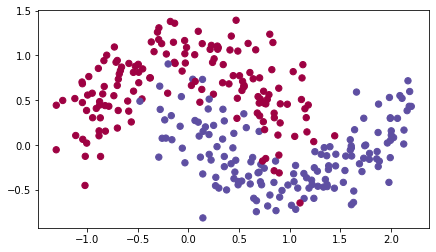

In [34]:
train_X, train_Y = opt_utils.load_dataset(is_plot=True)


定义模型：  

In [36]:
def model(X,Y,layers_dims,optimizer,learning_rate=0.0007,
          mini_batch_size=64,beta=0.9,beta1=0.9,beta2=0.999,
          epsilon=1e-8,num_epochs=10000,print_cost=True,is_plot=True):
    
    """
    可以运行在不同优化器模式下的3层神经网络模型。
    
    参数：
        X - 输入数据，维度为（2，输入的数据集里面样本数量）
        Y - 与X对应的标签
        layers_dims - 包含层数和节点数量的列表
        optimizer - 字符串类型的参数，用于选择优化类型，【 "gd" | "momentum" | "adam" 】
        learning_rate - 学习率
        mini_batch_size - 每个小批量数据集的大小
        beta - 用于动量优化的一个超参数
        beta1 - 用于计算梯度后的指数衰减的估计的超参数
        beta1 - 用于计算平方梯度后的指数衰减的估计的超参数
        epsilon - 用于在Adam中避免除零操作的超参数，一般不更改
        num_epochs - 整个训练集的遍历次数，（视频2.9学习率衰减，1分55秒处，视频中称作“代”）,相当于之前的num_iteration
        print_cost - 是否打印误差值，每遍历1000次数据集打印一次，但是每100次记录一个误差值，又称每1000代打印一次
        is_plot - 是否绘制出曲线图
        
    返回：
        parameters - 包含了学习后的参数
        
    """
    L = len(layers_dims)
    costs = []
    t = 0 #每学习完一个minibatch就增加1
    seed = 10 #随机种子
    
    #初始化参数
    parameters = opt_utils.initialize_parameters(layers_dims)
    
    #选择优化器
    if optimizer == "gd":
        pass #不使用任何优化器，直接使用梯度下降法
    elif optimizer == "momentum":
        v = initialize_velocity(parameters) #使用动量
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)#使用Adam优化
    else:
        print("optimizer参数错误，程序退出。")
        exit(1)
    
    #开始学习
    for i in range(num_epochs):
        #定义随机 minibatches,我们在每次遍历数据集之后增加种子以重新排列数据集，使每次数据的顺序都不同
        seed = seed + 1
        minibatches = random_mini_batches(X,Y,mini_batch_size,seed)
        
        for minibatch in minibatches:
            #选择一个minibatch
            (minibatch_X,minibatch_Y) = minibatch
            
            #前向传播
            A3 , cache = opt_utils.forward_propagation(minibatch_X,parameters)
            
            #计算误差
            cost = opt_utils.compute_cost(A3 , minibatch_Y)
            
            #反向传播
            grads = opt_utils.backward_propagation(minibatch_X,minibatch_Y,cache)
            
            #更新参数
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters,grads,learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentun(parameters,grads,v,beta,learning_rate)
            elif optimizer == "adam":
                t = t + 1 
                parameters , v , s = update_parameters_with_adam(parameters,grads,v,s,t,learning_rate,beta1,beta2,epsilon)
        #记录误差值
        if i % 100 == 0:
            costs.append(cost)
            #是否打印误差值
            if print_cost and i % 1000 == 0:
                print("第" + str(i) + "次遍历整个数据集，当前误差值：" + str(cost))
    #是否绘制曲线图
    if is_plot:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('epochs (per 100)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()
    
    return parameters


模型已经有了，我们就先来测试没有任何优化的梯度下降：

## 梯度下降测试

第0次遍历整个数据集，当前误差值：0.690735512291113
第1000次遍历整个数据集，当前误差值：0.6852725328458241
第2000次遍历整个数据集，当前误差值：0.6470722240719003
第3000次遍历整个数据集，当前误差值：0.6195245549970403
第4000次遍历整个数据集，当前误差值：0.5765844355950944
第5000次遍历整个数据集，当前误差值：0.6072426395968576
第6000次遍历整个数据集，当前误差值：0.5294033317684576
第7000次遍历整个数据集，当前误差值：0.46076823985930115
第8000次遍历整个数据集，当前误差值：0.4655860823990451
第9000次遍历整个数据集，当前误差值：0.46451797221676844


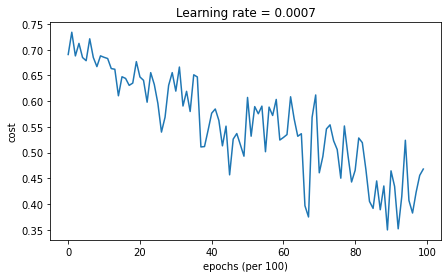

In [37]:
#使用普通的梯度下降
layers_dims = [train_X.shape[0],5,2,1]
parameters = model(train_X, train_Y, layers_dims, optimizer="gd",is_plot=True)



绘制分类的情况：

Accuracy: 0.7966666666666666


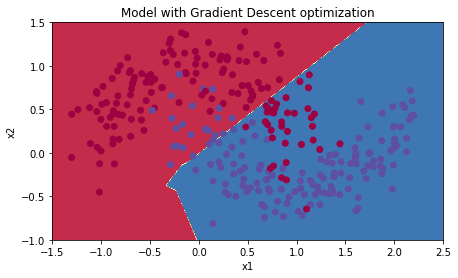

In [38]:
#预测
preditions = opt_utils.predict(train_X,train_Y,parameters)

#绘制分类图
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
opt_utils.plot_decision_boundary(lambda x: opt_utils.predict_dec(parameters, x.T), train_X, train_Y)


## 具有动量的梯度下降测试
因为这个例子比较简单，使用动量效果很小，但对于更复杂的问题，你可能会看到更好的效果。

第0次遍历整个数据集，当前误差值：0.6907412988351506
第1000次遍历整个数据集，当前误差值：0.6853405261267578
第2000次遍历整个数据集，当前误差值：0.6471448370095255
第3000次遍历整个数据集，当前误差值：0.6195943032076023
第4000次遍历整个数据集，当前误差值：0.5766650344073023
第5000次遍历整个数据集，当前误差值：0.607323821900647
第6000次遍历整个数据集，当前误差值：0.5294761758786997
第7000次遍历整个数据集，当前误差值：0.46093619004872366
第8000次遍历整个数据集，当前误差值：0.4657800937012721
第9000次遍历整个数据集，当前误差值：0.4647395967922748


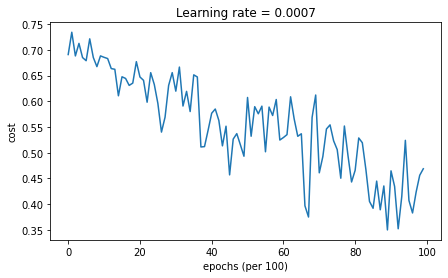

In [39]:
layers_dims = [train_X.shape[0],5,2,1]
#使用动量的梯度下降
parameters = model(train_X, train_Y, layers_dims, beta=0.9,optimizer="momentum",is_plot=True)


绘制分类的情况：

Accuracy: 0.7966666666666666


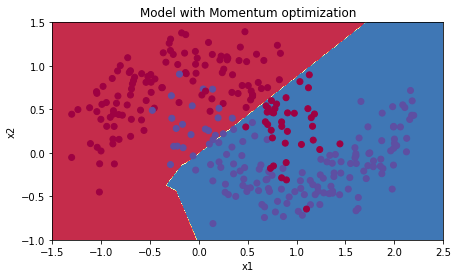

In [40]:
#预测
preditions = opt_utils.predict(train_X,train_Y,parameters)

#绘制分类图
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
opt_utils.plot_decision_boundary(lambda x: opt_utils.predict_dec(parameters, x.T), train_X, train_Y)



我们再来看看Adam的运行效果：

## Adam优化后的梯度下降

第0次遍历整个数据集，当前误差值：0.6905522446113365
第1000次遍历整个数据集，当前误差值：0.18550136438550574
第2000次遍历整个数据集，当前误差值：0.15083046575253206
第3000次遍历整个数据集，当前误差值：0.0744543857099718
第4000次遍历整个数据集，当前误差值：0.12595915651337158
第5000次遍历整个数据集，当前误差值：0.10434443534245487
第6000次遍历整个数据集，当前误差值：0.10067637504120651
第7000次遍历整个数据集，当前误差值：0.03165203013511563
第8000次遍历整个数据集，当前误差值：0.111972731312442
第9000次遍历整个数据集，当前误差值：0.19794007152465481


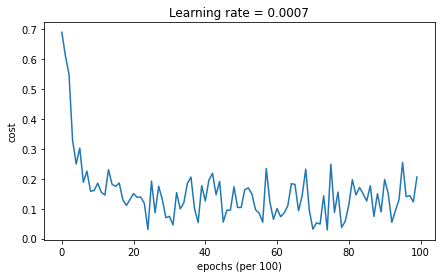

In [41]:
layers_dims = [train_X.shape[0], 5, 2, 1]
#使用Adam优化的梯度下降
parameters = model(train_X, train_Y, layers_dims, optimizer="adam",is_plot=True)



再来看以下分类的效果图：

Accuracy: 0.94


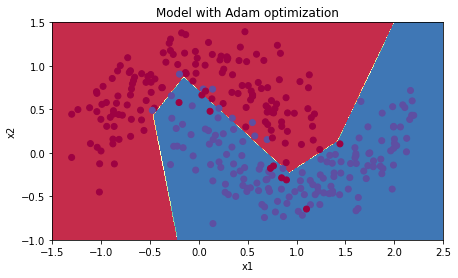

In [42]:
#预测
preditions = opt_utils.predict(train_X,train_Y,parameters)

#绘制分类图
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
opt_utils.plot_decision_boundary(lambda x: opt_utils.predict_dec(parameters, x.T), train_X, train_Y)


## 总结

| 优化算法 | 准确度  |	曲线平滑度 |
|:--------|:---------:|-----:|
| 梯度下降 | 79.7% | 震荡 |
| 具有动量的梯度下降算法 | 79.7% | 震荡 |
| Adam优化后的梯度下降 | 94% | 平滑 |


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;具有动量的梯度下降通常可以有很好的效果，但由于小的学习速率和简单的数据集所以它的影响几乎是轻微的。另一方面，Adam明显优于小批量梯度下降和具有动量的梯度下降，如果在这个简单的模型上运行更多时间的数据集，这三种方法都会产生非常好的结果，然而，我们已经看到Adam收敛得更快。

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Adam的一些优点包括相对较低的内存要求（虽然比梯度下降和动量下降更高）和通常运作良好，即使对参数进行微调（除了学习率 $\alpha$）